# Predict which Tweets are about real disasters and which are not.

This notebook is an exploration of basic NLP concepts and approaches this problem using Term Frequency-Inverse Document Frequency (TF-IDF) features. A basic random forest model is used to classify tweets.

### 1. Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import re
import nltk
nltk.download('wordnet')
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns

[nltk_data] Downloading package wordnet to C:\Users\AKASH
[nltk_data]     N\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
'unzip' is not recognized as an internal or external command,
operable program or batch file.


### 2. Importing Data

In [2]:
df_train = pd.read_csv(r"C:\Users\AKASH N\OneDrive\Desktop\Disaster Tweets Prediction NLP\train.csv")

In [3]:
df_test = pd.read_csv(r"C:\Users\AKASH N\OneDrive\Desktop\Disaster Tweets Prediction NLP\test.csv")

In [4]:
disaster_tweets_submission = pd.read_csv(r"C:\Users\AKASH N\OneDrive\Desktop\Disaster Tweets Prediction NLP\sample_submission.csv")

In [5]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


<Axes: xlabel='target', ylabel='count'>

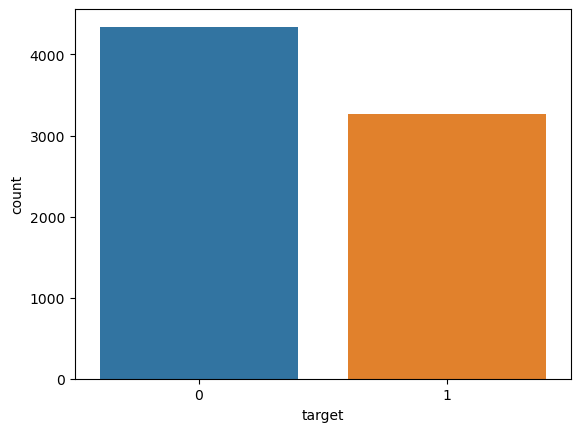

In [6]:
#check for class imbalance in distribution of target variable
sns.countplot(x = 'target', data = df_train)

In [7]:
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


### 3.Data Preprocessing

### 1.1 Data Cleanning

In [8]:
#set column width to max width
pd.set_option('display.max_colwidth', None)

In [9]:
#duplicate 'text' column, create new column called 'clean tweets'
df_train.insert(4, 'clean text', df_train['text'])
df_train

,id,keyword,location,text,clean text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California","13,000 people receive #wildfires evacuation orders in California",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1
...,...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse into nearby homes http://t.co/STfMbbZFB5,Two giant cranes holding a bridge collapse into nearby homes http://t.co/STfMbbZFB5,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control wild fires in California even in the Northern part of the state. Very troubling.,@aria_ahrary @TheTawniest The out of control wild fires in California even in the Northern part of the state. Very troubling.,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. http://t.co/zDtoyd8EbJ,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. http://t.co/zDtoyd8EbJ,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided with a car in Little Portugal. E-bike rider suffered serious non-life threatening injuries.,Police investigating after an e-bike collided with a car in Little Portugal. E-bike rider suffered serious non-life threatening injuries.,1


In [10]:
df_test

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, stay safe everyone."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all"
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan
...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTENERS XrWn
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city&amp;3others hardest hit. My yard looks like it was bombed. Around 20000K still without power
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/UtbXLcBIuY
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) http://t.co/3X6RBQJHn3


In [11]:
#remove html tags
df_train['clean text'] = df_train['clean text'].apply(lambda x: re.sub(r'<.*?>', '', x))

In [12]:
#compile emojis
emoji_pattern = re.compile("["
                        u"\U0001F600-\U0001F64F" #emoticons
                        u"\U00002702-\U000027B0" #dingbats
                        u"\U0001F680-\U0001F6FF" #transport and map symbols
                        u"\U0001F300-\U0001F5FF" #symbols and pictographs
                        u"\U0001F1E0-\U0001F1FF" #flags (iOS)
                        u"\U000024C2-\U0001F251" #enclosed characters
                        "]+")

#remove emojis
df_train['clean text'] = df_train['clean text'].apply(lambda x: emoji_pattern.sub(r'', x))

In [13]:
#remove twitter handles
df_train['clean text'] = df_train['clean text'].apply(lambda x: re.sub(r'@\S+', ' ', x))
df_train.head()

,id,keyword,location,text,clean text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California","13,000 people receive #wildfires evacuation orders in California",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1


In [14]:
#remove URLs
df_train['clean text'] = df_train['clean text'].apply(lambda x: re.sub(r'http\S+', '', x))
df_train.head()

,id,keyword,location,text,clean text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California","13,000 people receive #wildfires evacuation orders in California",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1


In [15]:
#remove punctuations and symbols
df_train['clean text'] = df_train['clean text'].apply(lambda x: re.sub(r'[^A-Za-z]+', ' ', x))
df_train.head()

,id,keyword,location,text,clean text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,Our Deeds are the Reason of this earthquake May ALLAH Forgive us all,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,Forest fire near La Ronge Sask Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,All residents asked to shelter in place are being notified by officers No other evacuation or shelter in place orders are expected,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",people receive wildfires evacuation orders in California,1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,Just got sent this photo from Ruby Alaska as smoke from wildfires pours into a school,1


In [16]:
#convert all letters to lowercase
df_train['clean text'] = df_train['clean text'].apply(lambda x: x.lower())

df_train.head()

,id,keyword,location,text,clean text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,our deeds are the reason of this earthquake may allah forgive us all,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,forest fire near la ronge sask canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,all residents asked to shelter in place are being notified by officers no other evacuation or shelter in place orders are expected,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",people receive wildfires evacuation orders in california,1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,just got sent this photo from ruby alaska as smoke from wildfires pours into a school,1


In [17]:
#remove stopwords
df_train['clean text'] = df_train['clean text'].apply(lambda x: [word for word in x.split() if word not in stopwords.words('english')])
df_train.head()

,id,keyword,location,text,clean text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,"[deeds, reason, earthquake, may, allah, forgive, us]",1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,"[forest, fire, near, la, ronge, sask, canada]",1
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,"[residents, asked, shelter, place, notified, officers, evacuation, shelter, place, orders, expected]",1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California","[people, receive, wildfires, evacuation, orders, california]",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,"[got, sent, photo, ruby, alaska, smoke, wildfires, pours, school]",1


In [18]:
#lemmatise text
df_train['clean text'] = df_train['clean text'].apply(lambda x: [WordNetLemmatizer().lemmatize(word) for word in x])
df_train.head()

,id,keyword,location,text,clean text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,"[deed, reason, earthquake, may, allah, forgive, u]",1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,"[forest, fire, near, la, ronge, sask, canada]",1
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,"[resident, asked, shelter, place, notified, officer, evacuation, shelter, place, order, expected]",1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California","[people, receive, wildfire, evacuation, order, california]",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,"[got, sent, photo, ruby, alaska, smoke, wildfire, pours, school]",1


In [19]:
#combine words in each row into a single string
df_train['clean text'] = df_train['clean text'].apply(lambda x: ' '.join(word for word in x))
df_train.head()

,id,keyword,location,text,clean text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,deed reason earthquake may allah forgive u,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,forest fire near la ronge sask canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,resident asked shelter place notified officer evacuation shelter place order expected,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",people receive wildfire evacuation order california,1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,got sent photo ruby alaska smoke wildfire pours school,1


### Data Cleaning (Auto)

In [20]:
def clean_text(text):
        
        #remove html tags
        text = re.sub('<*?>', '', text)
        
        #remove emojis
        emoji_pattern = re.compile("["
                        u"\U0001F600-\U0001F64F" #emoticons
                        u"\U00002702-\U000027B0" #dingbats
                        u"\U0001F680-\U0001F6FF" #transport and map symbols
                        u"\U0001F300-\U0001F5FF" #symbols and pictographs
                        u"\U0001F1E0-\U0001F1FF" #flags (iOS)
                        u"\U000024C2-\U0001F251" #enclosed characters
                        "]+")
        
        text = emoji_pattern.sub(r'', text)
        
        #remove twitter handles
        text = re.sub(r'@\S+', '', text)
        
        #remove URLs
        text = re.sub(r'http\S+', '', text)
        
        #remove punctuations and symbols
        text = re.sub(r'[^a-zA-Z]+', ' ', text)
        
        #convert all letters to lowercase
        text = text.lower()
        
        #remove stopwords
        text = [word for word in text.split() if word not in stopwords.words('english')]
        
        #lemmatise text
        text = [WordNetLemmatizer().lemmatize(word) for word in text]
        
        #recombine row entries into a single string
        text = ' '.join(word for word in text)
        
        return text

In [21]:
 df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, stay safe everyone."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all"
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [22]:
#clean text of test dataset and create new column for cleaned text
df_test['clean text'] = df_test['text'].apply(lambda x: clean_text(x))
df_test.head()

,id,keyword,location,text,clean text
0,0,NaN,NaN,Just happened a terrible car crash,happened terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, stay safe everyone.",heard earthquake different city stay safe everyone
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all",forest fire spot pond goose fleeing across street cannot save
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,apocalypse lighting spokane wildfire
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,typhoon soudelor kill china taiwan


### 1.2 Word Vectorisation with TF-IDF

In [23]:
#obtain training and test datasets of text data and target values
x_train = df_train['clean text'].values
x_test = df_test['clean text'].values
y_train = df_train['target']

In [24]:
x_train

array(['deed reason earthquake may allah forgive u',
       'forest fire near la ronge sask canada',
       'resident asked shelter place notified officer evacuation shelter place order expected',
       ..., 'utc km volcano hawaii',
       'police investigating e bike collided car little portugal e bike rider suffered serious non life threatening injury',
       'latest home razed northern california wildfire abc news'],
      dtype=object)

In [25]:
x_test

array(['happened terrible car crash',
       'heard earthquake different city stay safe everyone',
       'forest fire spot pond goose fleeing across street cannot save',
       ..., 'green line derailment chicago',
       'meg issue hazardous weather outlook hwo',
       'cityofcalgary activated municipal emergency plan yycstorm'],
      dtype=object)

In [26]:
y_train

0       1
1       1
2       1
3       1
4       1
       ..
7608    1
7609    1
7610    1
7611    1
7612    1
Name: target, Length: 7613, dtype: int64

In [27]:
#initialise tf-idf vectoriser to enable fitting of training text data
tfidf_vectoriser = TfidfVectorizer()

#fit and transform the text data for the training set
tfidf_xtrain = tfidf_vectoriser.fit_transform(x_train)

#vectorise words in the text data of the test set
tfidf_xtest = tfidf_vectoriser.transform(x_test)

In [28]:
tfidf_xtrain

<7613x12634 sparse matrix of type '<class 'numpy.float64'>'
	with 63726 stored elements in Compressed Sparse Row format>

In [29]:
tfidf_xtest

<3263x12634 sparse matrix of type '<class 'numpy.float64'>'
	with 24484 stored elements in Compressed Sparse Row format>

### Model Building

### Random Forest Classifier

In [30]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
#initialise random forest model
rf_classifier = RandomForestClassifier(n_estimators=100, random_state = 42)

In [31]:
#fit data to the model
rf_classifier.fit(tfidf_xtrain, y_train)

RandomForestClassifier(random_state=42)

In [32]:
#predict class labels for the test data
y_pred = rf_classifier.predict(tfidf_xtest)

In [33]:
y_pred

array([1, 1, 1, ..., 1, 1, 0], dtype=int64)

In [34]:
# Create a submission DataFrame
Disaster_tweets = pd.DataFrame({
    'id': df_test['id'],
    'target': y_pred
})

In [35]:
Disaster_tweets['target'] = y_pred

In [41]:
# Display the first few rows of the DataFrame
print(Disaster_tweets)

         id  target
0         0       1
1         2       1
2         3       1
3         9       1
4        11       1
...     ...     ...
3258  10861       1
3259  10865       1
3260  10868       1
3261  10874       1
3262  10875       0

[3263 rows x 2 columns]


In [37]:
# Save the DataFrame to a CSV file
Disaster_tweets.to_csv('submission.csv', index=False)

In [39]:
# Display the statistical summary of the DataFrame
print(Disaster_tweets.describe())

                 id      target
count   3263.000000  3263.00000
mean    5427.152927     0.36255
std     3146.427221     0.48081
min        0.000000     0.00000
25%     2683.000000     0.00000
50%     5500.000000     0.00000
75%     8176.000000     1.00000
max    10875.000000     1.00000
